In [32]:
import json
import arxiv
import requests
from pathlib import Path
import os
import re
from dotenv import load_dotenv
from copy import deepcopy
from tqdm import tqdm

from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

from openai import OpenAI
import openai
from prompt import * 

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

class CitationLinker():
    def __init__ (self, config):
        self.target_id = config['arxiv_id']
        self.preprocess_threhsold = config['preprocess_threhsold']
        self.reference_ratio = config['reference_ratio']
        self.reference_condition = config['reference_condition']
        self.model = config['model']

        self.essay_dir = Path(config['essay_dir'])
        self.result_dir = Path(config['result_dir'])
        CitationLinker.create_directory_if_not_exists(self.essay_dir)
        CitationLinker.create_directory_if_not_exists(self.result_dir)

        self.title = None
        self.authors = None
        self.submitted = None
        self.abstract = None
        self.pdf_url = None

        self.basic_keys = ["Title", "Authors", "Submitted" ,"Abstract"]
        self.references = ['References']
        
        self.content_config = config['content_keys']
        self.content_keys = [value_dict["name"] for _, value_dict in self.content_config.items()]
        
        # self.summarize_keys = list(set(self.content_keys) - set(self.references))
        # self.reference_count_keys = [key for key in self.content_keys if key not in set(self.basic_keys + self.references)]
    
    @staticmethod
    def create_directory_if_not_exists(directory_path):
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
            print(f"디렉토리 '{directory_path}'가 생성되었습니다.")
        else:
            raise FileExistsError(f"에러: '{directory_path}' 디렉토리가 이미 존재합니다.")

    def _search_arxiv_pdf(self, arxiv_id):
        search = arxiv.Search(id_list=[arxiv_id])
        for result in search.results():
            break
        print(f"📌 Title: {result.title}")
        print(f"📝 Authors: {', '.join([author.name for author in result.authors])}")
        print(f"📅 Submitted: {result.published}")
        print(f"🔗 PDF Link: {result.pdf_url}")
        print(f"📝 Abstract:\n{result.summary}")
        self.title = result.title
        self.authors = ', '.join([author.name for author in result.authors])
        self.submitted = str(result.published)
        self.abstract = result.summary
        self.pdf_url = result.pdf_url

    def _download_arxiv_pdf(self, pdf_url, save_path):
        response = requests.get(pdf_url, stream=True)
        if response.status_code == 200:
            with open(save_path, "wb") as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
        print("논문 저장 완료!")

    def _fetch_arxiv_paper(self, title, max_results=30):
        
        search = arxiv.Search(
            query=title,
            max_results=max_results, 
            sort_by=arxiv.SortCriterion.Relevance
        )

        for result in search.results():
            if title[10:-10].lower().replace(" ", "") in result.title.lower().replace(" ", ""):
                return ( {
                    "title": result.title,
                    "abstract": result.summary,
                    "pdf_url": result.pdf_url
                })
            
        return None 

    def _preprocess(self, save_path):
        # 데이터를 불러와 섹션 별로 나눕니다.
        loader = UnstructuredPDFLoader(save_path)
        documents = loader.load()
        processed_output = {}
        for key, value_dict in self.content_config.items():
            if value_dict['name'] == "Title":
                processed_output[value_dict['name']]=self.title
            elif value_dict['name'] == "Authors":
                processed_output[value_dict['name']]=self.authors
            elif value_dict['name'] == "Submitted":
                processed_output[value_dict['name']]=self.submitted
            elif value_dict['name'] == "Abstract":    
                processed_output[value_dict['name']]=self.abstract
            else:
                processed_output[value_dict['name']]=documents[0].page_content.split(value_dict['deliminators']['forward'])[-1].split(value_dict['deliminators']['backward'])[0]

        # basic_key가 아닌 섹션 중 threshold 미만으로 잘리면 모두 없앱니다.
        threshold = self.preprocess_threhsold
        for key in self.content_keys:
            if key not in self.basic_keys:
                result = []
                for text in processed_output[key].split("\n"):
                    if len(text) >= threshold:
                        result.append(text)
                processed_output[key] = "\n".join(result)
        
        # 2000자 단위로 모두 자릅니다.
        text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=2000, 
                chunk_overlap=0  
            )
        
        for key in self.content_keys:
            documents = text_splitter.create_documents([processed_output[key]])
            for doc in documents:
                doc.metadata = {"Title": self.title, "Key": key} 
            processed_output[key] = documents

        return processed_output
    
    @staticmethod
    def _message_to_openai(message, model):
        response = client.chat.completions.create(
            model=model,
            store=True,
            messages=[{"role": "user", "content": message}],
            temperature=0
        )
        return response

    def forward(self):

        # 논문 id를 받아서 논문을 다운 받습니다.
        self._search_arxiv_pdf(arxiv_id=self.target_id)
        title = self.title
        save_path = self.essay_dir / f"0-{title[:15]}.pdf"
        self._download_arxiv_pdf(
            pdf_url=self.pdf_url, 
            save_path=save_path
        )

        # 텍스트 전처리
        processed_output = self._preprocess(
            save_path=save_path
        )

        # 기본 요약
        essay = ""
        for key in self.content_keys:
            if key not in self.references:
                for doc in processed_output[key]:
                    essay += doc.page_content + "\n\n"
        basic_summarize_message = basic_summarize_template.format(essay=essay)
        response = CitationLinker._message_to_openai(message=basic_summarize_message, model=self.model)
        with open(self.result_dir/"basic_summary.json", 'w', encoding="utf-8") as f:
            json.dump(response.choices[0].message.content, f, ensure_ascii=False, indent=4)

        # 참고문헌 목록화
        reference_extraction_message = reference_extraction_template.format(references=processed_output['References'])
        flag = True
        while flag:
            response = CitationLinker._message_to_openai(message=reference_extraction_message, model=self.model)
            text = response.choices[0].message.content
            text = re.sub("```json","",text)
            text = re.sub("```","",text)
            json_data = json.loads(text)
            flag = False
            
        reference_dict = {}
        for key, dict_data in json_data.items():
            dict_data['Counter'] = 0
            dict_data['Context'] = []
            reference_dict[key] = dict_data
        processed_output['References'] = deepcopy(reference_dict)

        # 인용횟수 counting
        for index in range(len(reference_count_template_dict)):
            result = []
            for key in self.content_keys:
                if key not in self.basic_keys + self.references:
                    for essay in processed_output[key]:
                        reference_count_message = reference_count_template_dict[str(index)].format(references=reference_dict, essay=essay, condition=self.reference_condition)
                        response = CitationLinker._message_to_openai(reference_count_message, model=self.model)
                        try:
                            text = response.choices[0].message.content
                            text = re.sub("```json","",text)
                            text = re.sub("```","",text)
                            text_data = json.loads(text)
                            result.append(text_data)
                        except: 
                            text_data = None
                        # items['References'] = text_data

            for data in result:
                for key, value_dict in data.items():
                    processed_output["References"][key]['Counter'] += value_dict['Counter']
                    processed_output["References"][key]['Context'].extend(value_dict['Context'])

        # reference 논문 다운 받아오기
        for index in range(len(processed_output['References'])):
            title = processed_output['References'][str(index+1)]['Title']
            try :
                paper_info = self._fetch_arxiv_paper(title)
                if paper_info is None:
                    paper_info = self._fetch_arxiv_paper(title, 150)
            except Exception as e:
                print(index+1,"번째 논문 예외 발생: ", e)
                try :
                    paper_info = self._fetch_arxiv_paper(title, None)
                except:
                    paper_info = None

            if paper_info is not None:
                pdf_url = paper_info['pdf_url']
                abstract = paper_info['abstract']
                processed_output['References'][str(index+1)]['abstract'] = abstract
                processed_output['References'][str(index+1)]['pdf_url'] = pdf_url
                save_path = self.essay_dir / (str(index+1)+ "-" + paper_info['title'][:15]+".pdf")
                self._download_arxiv_pdf(pdf_url, save_path)
                print(index+1,"번째 논문 다운로드 완료")
            
            else:
                pdf_url = None
                abstract = None
                processed_output['References'][str(index+1)]['abstract'] = abstract
                processed_output['References'][str(index+1)]['pdf_url'] = pdf_url
                print(index+1,"번째 논문 다운로드 실패")
                print(f"    {processed_output['References'][str(index+1)]['Title']}")

        # 논문 다운로드 후, 질문 축소
        filtered_reference_dict = { key: value for key, value in processed_output['References'].items() if value['pdf_url'] is not None}
        nums = int(round(len(processed_output['References'])*self.reference_ratio, 0))
        related_reference = dict(sorted(filtered_reference_dict.items(), key=lambda x:x[1]['Counter'], reverse=True)[:nums])
        total_related_reference = dict(sorted(filtered_reference_dict.items(), key=lambda x:x[1]['Counter'], reverse=True))
        # print(total_related_reference)
        # result['total_reference_result_dict'] = total_related_reference
        with open(self.result_dir/"reference_count.json", 'w', encoding="utf-8") as f:
            json.dump(total_related_reference, f, ensure_ascii=False, indent=4)

        for index in related_reference.keys():
            query_list = related_reference[index]['Context']
            user_message = question_reduction_template.format(text_list=query_list)
            response = CitationLinker._message_to_openai(user_message, model=self.model)
            related_reference[index]['Questions'] = response.choices[0].message.content

        # reference와의 접점을 찾기 위한 요약
        main_essay = ""
        for key in self.basic_keys:
            for doc in processed_output[key]:
                main_essay += (doc.page_content + "\n\n")

        for index in tqdm(related_reference.keys(), desc="인용 논문과의 관련 지점 정리..."):
            title = related_reference[index]['Title']
            questions = related_reference[index]['Questions']
        
            for path in self.essay_dir.rglob("*.pdf"):
                if path.name.split("-")[0] == index:
                    break
        
            loader = UnstructuredPDFLoader(path)
            documents = loader.load()
            essay = documents[0].page_content
            essay = "\n".join([text for text in essay.split("\n") if len(text) >= self.preprocess_threhsold])
            reference_qna_message = reference_qna_template.format(essay = essay, questions=questions, title=title)
            response = CitationLinker._message_to_openai(reference_qna_message, model=self.model)
            summary = response.choices[0].message.content
            related_reference[index]['Summary'] = summary
            
            research_progress_message = research_progress_template.format(title=processed_output['Title'], essay=main_essay, qna = summary)
            response = CitationLinker._message_to_openai(research_progress_message,model=self.model)
            summary_qna = response.choices[0].message.content
            related_reference[index]['Summary_QnA'] = summary_qna

        with open(self.result_dir/"reference_qna.json", 'w', encoding="utf-8") as f:
            json.dump(related_reference, f, ensure_ascii=False, indent=4)

if __name__ == "__main__":

    with open("config.json",'r') as f:
        config = json.load(f)

    citation_linker = CitationLinker(config)
    citation_linker.forward()

디렉토리 'reference'가 생성되었습니다.
디렉토리 'result'가 생성되었습니다.


/tmp/ipykernel_107714/2208113697.py:61: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


📌 Title: How Do Large Language Models Acquire Factual Knowledge During Pretraining?
📝 Authors: Hoyeon Chang, Jinho Park, Seonghyeon Ye, Sohee Yang, Youngkyung Seo, Du-Seong Chang, Minjoon Seo
📅 Submitted: 2024-06-17 17:54:40+00:00
🔗 PDF Link: http://arxiv.org/pdf/2406.11813v3
📝 Abstract:
Despite the recent observation that large language models (LLMs) can store
substantial factual knowledge, there is a limited understanding of the
mechanisms of how they acquire factual knowledge through pretraining. This work
addresses this gap by studying how LLMs acquire factual knowledge during
pretraining. The findings reveal several important insights into the dynamics
of factual knowledge acquisition during pretraining. First, counterintuitively,
we observe that pretraining on more data shows no significant improvement in
the model's capability to acquire and maintain factual knowledge. Next, there
is a power-law relationship between training steps and forgetting of
memorization and generalizatio

/tmp/ipykernel_107714/2208113697.py:90: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


논문 저장 완료!
1 번째 논문 다운로드 완료
논문 저장 완료!
2 번째 논문 다운로드 완료
논문 저장 완료!
3 번째 논문 다운로드 완료
논문 저장 완료!
4 번째 논문 다운로드 완료
논문 저장 완료!
5 번째 논문 다운로드 완료
논문 저장 완료!
6 번째 논문 다운로드 완료
논문 저장 완료!
7 번째 논문 다운로드 완료
논문 저장 완료!
8 번째 논문 다운로드 완료
논문 저장 완료!
9 번째 논문 다운로드 완료
논문 저장 완료!
10 번째 논문 다운로드 완료
논문 저장 완료!
11 번째 논문 다운로드 완료
논문 저장 완료!
12 번째 논문 다운로드 완료
논문 저장 완료!
13 번째 논문 다운로드 완료
논문 저장 완료!
14 번째 논문 다운로드 완료
논문 저장 완료!
15 번째 논문 다운로드 완료
16 번째 논문 다운로드 실패
    Measuring causal effects of data statistics on language model’s ’factual’ predictions
논문 저장 완료!
17 번째 논문 다운로드 완료
논문 저장 완료!
18 번째 논문 다운로드 완료
논문 저장 완료!
19 번째 논문 다운로드 완료
논문 저장 완료!
20 번째 논문 다운로드 완료
21 번째 논문 다운로드 실패
    Olmo: Accelerating the science of language models
22 번째 논문 다운로드 실패
    Investigating learning dynamics of bert fine-tuning
23 번째 논문 다운로드 실패
    Training compute-optimal large language models
논문 저장 완료!
24 번째 논문 다운로드 완료
논문 저장 완료!
25 번째 논문 다운로드 완료
논문 저장 완료!
26 번째 논문 다운로드 완료
논문 저장 완료!
27 번째 논문 다운로드 완료
논문 저장 완료!
28 번째 논문 다운로드 완료
논문 저장 완료!
29 번째 논문 다운로드 완료
30 번째 논문 다운로드 실

인용 논문과의 관련 지점 정리...: 100%|██████████| 11/11 [08:20<00:00, 45.48s/it]


In [2]:
import json
with open("result/240611813/basic_summary.json", 'r') as f:
    basic_summary = json.load(f)

print(basic_summary)

### 1. 기본 정보
1) 제목: How Do Large Language Models Acquire Factual Knowledge During Pretraining?
2) 저자: Hoyeon Chang, Jinho Park, Seonghyeon Ye, Sohee Yang, Youngkyung Seo, Du-Seong Chang, Minjoon Seo

### 2. 연구 목적
1) 문제의식: 대형 언어 모델의 사실적 지식 습득 메커니즘
2) 설명: 최근 대형 언어 모델(LLM)이 상당한 사실적 지식을 저장할 수 있다는 관찰이 있었으나, 이들이 사전 훈련 중 사실적 지식을 어떻게 습득하는지에 대한 이해는 부족하다. 본 연구는 LLM의 사실적 지식 습득 과정을 분석하여, 훈련 데이터와 훈련 조건이 지식 습득에 미치는 영향을 규명하고자 한다. 이를 통해 LLM의 훈련 동역학을 이해하고, 향후 모델 성능 향상에 기여할 수 있는 통찰을 제공하는 것을 목표로 한다.

### 3. 연구 방법
1) 실험 방법: 연구진은 LLM의 중간 훈련 체크포인트를 사용하여, 이전에 접하지 않은 사실적 지식을 주입하고, 다양한 조건에서 지식 습득의 진행 상황을 모니터링하였다. 이를 통해 메모리화와 일반화 측면에서 LLM의 사실적 지식 습득을 분석하였다.
2) 데이터: FICTIONAL KNOWLEDGE 데이터셋을 구성하여, 허구적이지만 현실적인 개체에 대한 설명을 포함한 문장을 주입하였다. 이 데이터셋은 GPT-4를 통해 생성되었다.
3) 모델 및 분석 방법: OLMo 모델을 사용하여, 주입된 지식에 대한 로그 확률을 평가하고, 지식 습득의 효과성과 유지 가능성을 측정하였다. 또한, 다양한 주입 시나리오와 훈련 조건을 비교 분석하였다.

### 4. 주요 결과
1) 연구의 주요 발견: LLM은 사실적 지식을 습득할 때, 미세한 확률 증가를 누적하는 방식으로 작동하며, 훈련 데이터의 중복이 빠른 망각을 초래한다는 것을 발견하였다. 또한, 모델 크기와 훈련 배치 크기가 지식 습득의 강건성에

In [4]:
import json
with open("result/240611813/reference_qna.json", 'r') as f:
    reference_qna = json.load(f)

for key, value_dict in reference_qna.items():
    print(value_dict['Summary'])
    print()
    print(value_dict['Summary_QnA'])
    print("##########")
    print()

인용 논문 제목 (Title): Scaling laws for neural language models

1. **질문 :** 최근 LLM에 대한 관심이 급증하고 있으며, [23]과 [27]은 LLM의 성능이 모델 크기와 사전 훈련 코퍼스의 크기와 긍정적으로 상관관계가 있는 스케일링 법칙을 따름을 보고했습니다.
   - **답변 :** LLM의 성능은 모델 크기와 사전 훈련 데이터의 양에 따라 증가하며, 이는 스케일링 법칙에 의해 설명됩니다. 즉, 모델의 크기와 데이터 양이 증가할수록 성능이 향상된다는 것입니다.
   - **근거 :** "The loss scales as a power-law with model size, dataset size, and the amount of compute used for training."

2. **질문 :** 이러한 연구들은 주로 사전 훈련이 완료된 후 LLM에 인코딩된 사실적 지식을 조사하는 데 초점을 맞추었습니다.
   - **답변 :** 연구들은 LLM이 사전 훈련 후에 얼마나 많은 사실적 지식을 인코딩하고 있는지를 분석하는 데 중점을 두고 있습니다. 이는 LLM의 지식 기반을 이해하는 데 중요한 요소입니다.
   - **근거 :** "These works have mainly focused on investigating the factual knowledge encoded in LLMs after pretraining is complete."

3. **질문 :** 다음으로, 모델이 i번째로 지식을 제시받은 후 사실적 지식의 로그 확률에서 즉각적인 개선을 정량화하기 위한 메트릭을 정의합니다.
   - **답변 :** 모델이 특정 지식을 반복적으로 접할 때, 그 지식에 대한 로그 확률의 즉각적인 개선을 측정하기 위한 메트릭을 설정하는 것이 중요합니다. 이는 모델의 학습 효과를 평가하는 데 유용합니다.
   - **근거 :** "Next, we define a metric to quantify the immedia

/tmp/ipykernel_31185/2671135761.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Index", y="Score", data=df.iloc[:nums], palette="coolwarm")


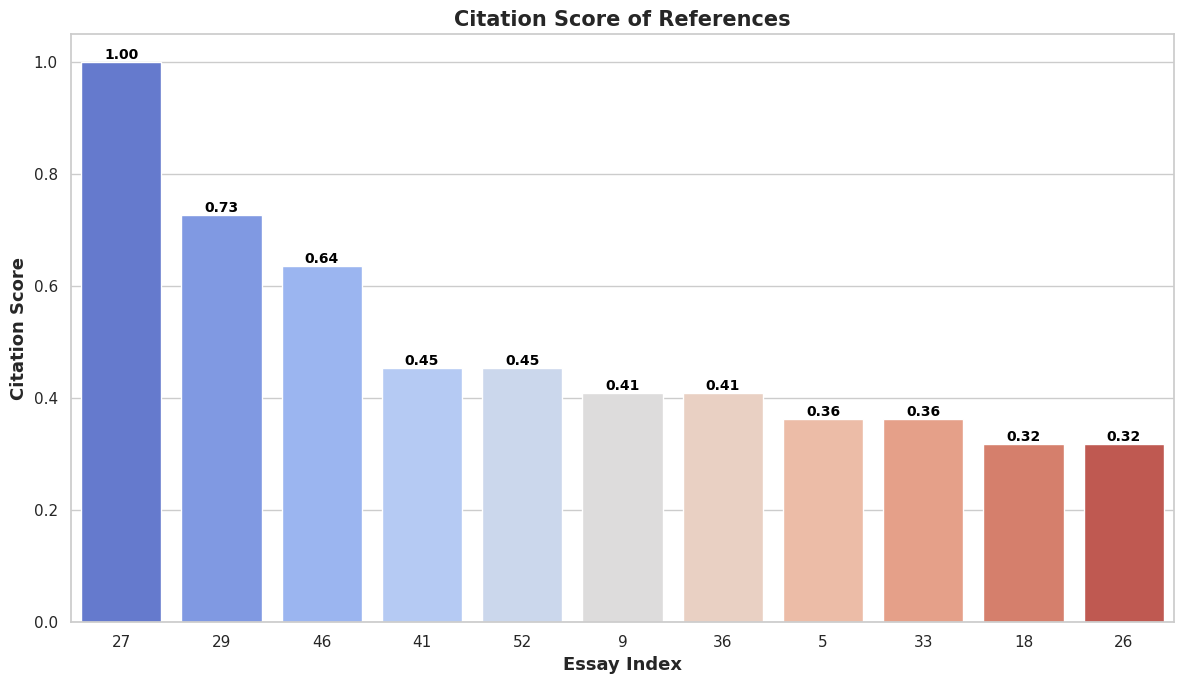

In [34]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

def load_json(file_path):
    if Path(file_path).exists():
        with open(file_path, "r", encoding="utf-8") as f:
            return json.load(f)
    else:
        return None

arxiv_id = "2406.11813"
arxiv_id = arxiv_id.replace(".","")

reference_count_path = Path("result") / arxiv_id / "reference_count.json"
reference_count = load_json(reference_count_path)

reference_qna_path = Path("result") / arxiv_id / "reference_qna.json"
reference_qna = load_json(reference_qna_path)

data_dict = {}
for i, (key, value_dict) in enumerate(reference_count.items()):
    data_dict[i] = {
        "Title":value_dict["Title"],
        "Counter":value_dict["Counter"],
        "Index":key
    }

df = pd.DataFrame(data_dict).T
max_value = df.iloc[0]["Counter"]
df['Score'] = df['Counter']/max_value

nums = len(reference_qna)

# 🌟 Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 🎨 Seaborn 막대 그래프 그리기 (색상 변경)
plt.figure(figsize=(12, 7))
ax = sns.barplot(x="Index", y="Score", data=df.iloc[:nums], palette="coolwarm")

# X축 라벨 90도 회전 & 폰트 크기 조정
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# 라벨 추가
plt.xlabel("Essay Index", fontsize=13, fontweight='bold')
plt.ylabel("Citation Score", fontsize=13, fontweight='bold')
plt.title("Citation Score of References", fontsize=15, fontweight='bold')

# 막대 위에 값 표시 (숫자)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight="bold", color="black")

# 여백 조정
plt.tight_layout()

# 그래프 출력
plt.show()


,Title,Counter,Index
0,Scaling laws for neural language models,22,27
1,Deduplicating training data makes language mod...,16,29
2,Memorization without overfitting: Analyzing th...,14,46
3,Are emergent abilities of large language model...,10,41
4,To repeat or not to repeat: Insights from scal...,10,52
5,Language models are few-shot learners,9,9
6,Language models as knowledge bases?,9,36
7,"Physics of language models: Part 3.2, knowledg...",8,5
8,An empirical study of catastrophic forgetting ...,8,33
9,Does fine-tuning llms on new knowledge encoura...,7,18


In [41]:
importance_list

[1.0,
 0.75,
 0.5833333333333334,
 0.4166666666666667,
 0.4166666666666667,
 0.375,
 0.375,
 0.375,
 0.3333333333333333,
 0.3333333333333333,
 0.2916666666666667,
 0.2916666666666667,
 0.25,
 0.25,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.125,
 0.125,
 0.125,
 0.08333333333333333,
 0.041666666666666664,
 0.041666666666666664,
 0.041666666666666664,
 0.041666666666666664,
 0.041666666666666664,
 0.041666666666666664,
 0.0,
 0.0,
 0.0]

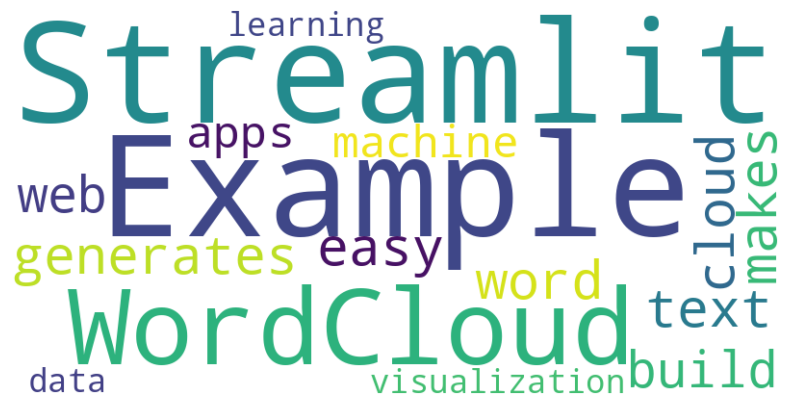

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 텍스트 데이터
text = """
Streamlit WordCloud Example. This example generates a word cloud from text.
Streamlit makes it easy to build web apps for machine learning and data visualization.
"""

# 워드클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # 축 제거
plt.show()


In [36]:
result_dict = {}
for key, value_dict in reference_qna.items():
    result_dict[key] = {"Title" : value_dict["Title"], "refer" : value_dict["Summary"] + "\n\n접점 요약 \n\n" + value_dict["Summary_QnA"] }

'### 1. 기본 정보\n1) 제목: How Do Large Language Models Acquire Factual Knowledge During Pretraining?\n2) 저자: Hoyeon Chang, Jinho Park, Seonghyeon Ye, Sohee Yang, Youngkyung Seo, Du-Seong Chang, Minjoon Seo\n\n### 2. 연구 목적\n1) 문제의식: 대형 언어 모델의 사실적 지식 습득 메커니즘\n2) 설명: 최근 대형 언어 모델(LLM)이 상당한 사실적 지식을 저장할 수 있다는 관찰이 있었으나, 이들이 사전 훈련 중 사실적 지식을 어떻게 습득하는지에 대한 이해는 부족하다. 본 연구는 LLM의 사실적 지식 습득 과정을 분석하여, 훈련 데이터와 훈련 조건이 지식 습득에 미치는 영향을 규명하고자 한다. 이를 통해 LLM의 훈련 동역학을 이해하고, 향후 모델 성능 향상에 기여할 수 있는 통찰을 제공하는 것을 목표로 한다.\n\n### 3. 연구 방법\n1) 실험 방법: 연구진은 LLM의 중간 훈련 체크포인트를 사용하여, 이전에 접하지 않은 사실적 지식을 주입하고, 다양한 조건에서 지식 습득의 진행 상황을 모니터링하였다. 이를 통해 메모리화와 일반화 측면에서 LLM의 사실적 지식 습득을 분석하였다.\n2) 데이터: FICTIONAL KNOWLEDGE 데이터셋을 구성하여, 허구적이지만 현실적인 개체에 대한 설명을 포함한 문장을 주입하였다. 이 데이터셋은 GPT-4를 통해 생성되었다.\n3) 모델 및 분석 방법: OLMo 모델을 사용하여, 주입된 지식에 대한 로그 확률을 평가하고, 지식 습득의 효과성과 유지 가능성을 측정하였다. 또한, 다양한 주입 시나리오와 훈련 조건을 비교 분석하였다.\n\n### 4. 주요 결과\n1) 연구의 주요 발견: LLM은 사실적 지식을 습득할 때, 미세한 확률 증가를 누적하는 방식으로 작동하며, 훈련 데이터의 중복이 빠른 망각을 초래한다는 것을 발견하였다. 또한, 모델 크기와 훈련 배치 

In [43]:
merged_text = ""
for key, value_dict in reference_qna.items():
    merged_text += value_dict['Summary'] + "인용 논문과의 접점 결론" + value_dict['Summary_QnA'] + "###"

prompt_text = basic_summary + "\n\n" + merged_text 

In [42]:
print(merged_text)

인용 논문 제목 (Title): Scaling laws for neural language models

1. **질문 :** 최근 LLM에 대한 관심이 급증하고 있으며, [23]과 [27]은 LLM의 성능이 모델 크기와 사전 훈련 코퍼스의 크기와 긍정적으로 상관관계가 있는 스케일링 법칙을 따름을 보고했습니다.
   - **답변 :** LLM의 성능은 모델 크기와 사전 훈련 데이터의 양에 따라 증가하며, 이는 스케일링 법칙에 의해 설명됩니다. 즉, 모델의 크기와 데이터 양이 증가할수록 성능이 향상된다는 것입니다.
   - **근거 :** "The loss scales as a power-law with model size, dataset size, and the amount of compute used for training."

2. **질문 :** 이러한 연구들은 주로 사전 훈련이 완료된 후 LLM에 인코딩된 사실적 지식을 조사하는 데 초점을 맞추었습니다.
   - **답변 :** 연구들은 LLM이 사전 훈련 후에 얼마나 많은 사실적 지식을 인코딩하고 있는지를 분석하는 데 중점을 두고 있습니다. 이는 LLM의 지식 기반을 이해하는 데 중요한 요소입니다.
   - **근거 :** "These works have mainly focused on investigating the factual knowledge encoded in LLMs after pretraining is complete."

3. **질문 :** 다음으로, 모델이 i번째로 지식을 제시받은 후 사실적 지식의 로그 확률에서 즉각적인 개선을 정량화하기 위한 메트릭을 정의합니다.
   - **답변 :** 모델이 특정 지식을 반복적으로 접할 때, 그 지식에 대한 로그 확률의 즉각적인 개선을 측정하기 위한 메트릭을 설정하는 것이 중요합니다. 이는 모델의 학습 효과를 평가하는 데 유용합니다.
   - **근거 :** "Next, we define a metric to quantify the immedia